In [84]:
import tensorflow as tf
import keras as k
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random as r
import numpy as np
import cv2
import imghdr
import os
import itertools
import datetime

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.applications import ResNet50V2, Xception, EfficientNetB3, EfficientNetB4, EfficientNetB5
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from keras import backend
from collections import Counter
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
  
print(f'Tensorflow version {tf.version.VERSION}')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Tensorflow version 2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data processing

In [85]:
PATH_TRAIN = 'C:/Users/crims/Tensorflow/PublisherIdetification/realpublishers/training/'
PATH_TEST = 'C:/Users/crims/Tensorflow/PublisherIdetification/realpublishers/testing/'

class DataGenerator:
    def __init__(self, val_split, height, width, batch_size):
        self.val_split = val_split
        self.height = height
        self.width = width
        self.batch_size = batch_size
    
    def train_generator(self):    
        train_generator = ImageDataGenerator(rescale=1./255, validation_split=self.val_split)
        print('Training folder:')
        self.train_data = train_generator.flow_from_directory(PATH_TRAIN, target_size=(self.width, self.height),
                                                     class_mode = 'categorical', batch_size=BATCH_SIZE, 
                                                     subset = 'training')
        print('Validation folder:')
        self.valid_data = train_generator.flow_from_directory(PATH_TRAIN, target_size=(self.width, self.height),
                                                     class_mode = 'categorical', batch_size=self.batch_size, 
                                                     subset = 'validation')

    def test_generator(self):
        test_generator = ImageDataGenerator(rescale=1./255)
        print('Test folder:')
        self.test_data = test_generator.flow_from_directory(PATH_TEST, target_size=(WIDTH, HEIGHT), 
                                                   class_mode=None, batch_size=1, 
                                                   shuffle=False)
    def generator_info(self):
        self.class_counter = list(Counter(self.train_data.classes).values())
        self.class_names = list(self.train_data.class_indices)
        self.class_num = self.train_data.num_classes
        print(f'Class name and # {dict(zip(self.class_names, self.class_counter))}') 

    def clean_data(self):
        self.filenames = self.train_data.filenames
        n = 0
        while n < self.train_data.n:
            path = f'{PATH_TRAIN}{self.filenames[n]}'
            image = cv2.imread(path)
            img_type = imghdr.what(path)
            if img_type != "jpeg":
                print(f'Removing image from {path}')
                os.remove(path)
                n += 1
            else:
                n += 1
        print('All done!') 

In [100]:
# class ConfusionMatrix:
#     def plot_confusion_matrix(cm, class_names):
#       """
#       Returns a matplotlib figure containing the plotted confusion matrix.

#       Args:
#         cm (array, shape = [n, n]): a confusion matrix of integer classes
#         class_names (array, shape = [n]): String names of the integer classes
#       """
#       figure = plt.figure(figsize=(8, 8))
#       plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#       plt.title("Confusion matrix")
#       plt.colorbar()
#       tick_marks = np.arange(len(class_names))
#       plt.xticks(tick_marks, class_names, rotation=45)
#       plt.yticks(tick_marks, class_names)

#       # Normalize the confusion matrix.
#       cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

#       # Use white text if squares are dark; otherwise black.
#       threshold = cm.max() / 2.
#       for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         color = "white" if cm[i, j] > threshold else "black"
#         plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

#       plt.tight_layout()
#       plt.ylabel('True label')
#       plt.xlabel('Predicted label')
#       return figure

#     def log_confusion_matrix(epoch, logs):
#       # Use the model to predict the values from the validation dataset.
#       test_pred_raw = model.predict(x_test)
#       test_pred = np.argmax(test_pred_raw, axis=1)
#       y_test_cls = np.argmax(y_test, axis=1)

#       # Calculate the confusion matrix.
#       cm = confusion_matrix(y_test_cls, test_pred)

#       figure = plot_confusion_matrix(cm, class_names=class_names)
#       cm_image = plot_to_image(figure)

#       # Log the confusion matrix as an image summary.
#       with file_writer_cm.as_default():
#         tf.summary.image("Confusion Matrix", cm_image, step=epoch)

#     # Define the per-epoch callback to plot confusion metrics after each epoch.
#     cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## Model setup & parameters

In [146]:
class BuildModel:
    def __init__(self, network, pooling, optimizer, learn_rate, epochs, steps):
        self.network = network
        self.lr = learn_rate
        self.opt = optimizer
        self.pool = pooling
        self.epochs = epochs
        self.num_batch = steps
        self.val_batch = steps * dat1.val_split
        
    def compile_model(self):
        base = self.network(include_top=False, weights='imagenet', 
                     input_shape=(dat1.width, dat1.height, 3), pooling=self.pool)
        opt = self.opt(learning_rate=self.lr)
        
        x = base.output
        x = layers.Dense(dat1.class_num, activation='softmax')(x)
        self.model = tf.keras.Model(base.input, x)
        self.model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=opt)    
              
    def run_model(self, summary, save):
        if summary == True:
            self.model.summary()
            
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M")    
        tensorflow_callback = k.callbacks.TensorBoard(
            log_dir= f'tensorboard_logs/{self.network.__name__}{self.pool}_{self.opt.__name__}lr{self.lr}_E{self.epochs}B{dat1.batch_size}-{current_time}', 
            histogram_freq=1, write_graph=True, write_images=True)
        #file_writer_cm = tf.summary.create_file_writer(f'tensorboard_logs/{NETWORK}_{OPTIMIZER}_E{EPOCHS}B{BATCH_SIZE}_lr{LEARN_RATE}_pool{POOLING}/cm')       
        history = self.model.fit(dat1.train_data, validation_data=dat1.valid_data, 
                            callbacks=[tensorflow_callback], epochs=self.epochs, 
                            steps_per_epoch=self.num_batch , validation_steps=self.val_batch, 
                            batch_size=dat1.batch_size, verbose =1)
          
        if save == True:
            model.save(f'{NETWORK}_publisherid - {current_time}')


In [ ]:
dat1 = DataGenerator(0.25, 300, 200, 32)
dat1.train_generator()
dat1.generator_info()
mod1 = BuildModel(EfficientNetB4, 'avg', Adam, 1e-4, 15, 100) #xception ~ 5e-4, efficient ~ 9e-5
mod1.compile_model()
mod1.run_model(False, False)

Training folder:
Found 9809 images belonging to 4 classes.
Validation folder:
Found 3269 images belonging to 4 classes.
Class name and # {'IEEE': 144, 'Macmillan': 2586, 'Springer Nature': 5768, 'Wolters Kluwer Health': 1311}


C:\Users\crims\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/15
100/100 [==============================] - 65s 522ms/step - loss: 0.6745 - acc: 0.7631 - val_loss: 1.1567 - val_acc: 0.5775
Epoch 2/15
100/100 [==============================] - 48s 477ms/step - loss: 0.4000 - acc: 0.8637 - val_loss: 0.9254 - val_acc: 0.6212
Epoch 3/15
100/100 [==============================] - 48s 477ms/step - loss: 0.3232 - acc: 0.8819 - val_loss: 1.0927 - val_acc: 0.4725
Epoch 4/15
100/100 [==============================] - 48s 475ms/step - loss: 0.2860 - acc: 0.9038 - val_loss: 1.3401 - val_acc: 0.3913
Epoch 5/15
100/100 [==============================] - 47s 473ms/step - loss: 0.2344 - acc: 0.9199 - val_loss: 0.8437 - val_acc: 0.6737
Epoch 6/15
 94/100 [===========================>..] - ETA: 2s - loss: 0.1720 - acc: 0.9428

## Model evaluation 

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.ylim([0, 1])
# plt.xlabel('epoch')
# plt.xlim([0, EPOCHS])
# plt.grid()
# plt.legend(['train', 'valid'], loc='upper left')

# plt.subplot(122)
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.ylim([0.3, 1])
# plt.xlabel('epoch')
# plt.xlim([0, EPOCHS])
# plt.legend(['train', 'valid'], loc='upper left')
# plt.grid()
# plt.show()

## Predictor

In [212]:
class Predictor:
    def predict(self):
        n = r.randint(0, dat1.valid_data.n)
        filenames = dat1.valid_data.filenames
        path = f'{PATH_TRAIN}{filenames[n]}'
        pic = mpimg.imread(path)
        plt.axis('off')
        plt.imshow(pic)
        plt.show()

        img = tf.keras.preprocessing.image.load_img(path, target_size=(dat1.width, dat1.height))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_processed = tf.keras.applications.xception.preprocess_input(img_batch)

        prediction = mod1.model(img_processed, training=False)
        Top_index = np.argsort(np.max(prediction, axis=0))[-1]
        Second_index = np.argsort(np.max(prediction, axis=0))[-2]

        sort = np.sort(max(prediction))
        print(f'1st predict {dat1.class_names[Top_index]} with conf {round(sort[len(sort) - 1]*100)}%')
        print(f'2nd predict {dat1.class_names[Second_index]} with conf {round(sort[len(sort) - 2] * 100)}%')           
        print(f'Answer is {filenames[n][:]}')
        
    def batch_predict(self):
        gu = mod1.model.evaluate(dat1.valid_data, batch_size=dat1.batch_size, steps=10)


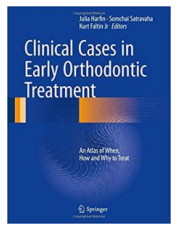

1st predict Springer Nature with conf 94%
2nd predict Macmillan with conf 4%
Answer is Springer Nature\Thumbnail262.jpg
10/10 [==============================] - 2s 154ms/step - loss: 2.2712 - acc: 0.2188


In [213]:
predict1 = Predictor()
predict1.predict()
predict1.batch_predict()